# Dependencies

In [19]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import math
from PIL import Image, ImageFilter
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import MaxPooling2D, Flatten, Dense

In [20]:
#Run the process on CPU

os.environ['CUDA_VISIBLE_DEVICES'] = ''

#### Auxillary Functions

In [21]:
def normalize(image):
    image /= 255.0
    image = np.round(image, 4)
    return image


def display_image(image_count, images, index, columns, fig_size):
    # Find the number of rows and columns required
    rows = max(math.ceil(image_count / columns), 1)
    cols = min(image_count, columns)
    if image_count % cols == 0:
        rows += 1
    fig, axes = plt.subplots(rows, cols, figsize=fig_size)

    # Iterate over each row and column in the figure and display an image
    for i in range(rows):
        for j in range(cols):

            # If this is the last row and there are empty columns, remove the axis
            if i == rows - 1 and j >= image_count % columns:
                axes[i, j].remove()
                continue

            axes[i, j].imshow(images[np.random.randint(index)].squeeze(), cmap='gray')
            axes[i, j].axis("off")


def image_center_justified(image, resize_shape):
    # Convert image to NumPy array
    img = np.array(image)
    
    # Find row and column means
    row_means = np.mean(img, axis=1)
    col_means = np.mean(img, axis=0)
    
    # Find top, bottom, left, and right boundaries of number
    top = np.argmax(row_means < np.mean(row_means))
    bottom = img.shape[0] - np.argmax(np.flip(row_means) < np.mean(row_means))
    left = np.argmax(col_means < np.mean(row_means))
    right = img.shape[1] - np.argmax(np.flip(col_means) < np.mean(row_means))
    
    # Crop image to number boundaries
    cropped = Image.fromarray(img[top:bottom, left:right])
    
    # Resize image 
    resized = cropped.resize(resize_shape, resample=Image.BILINEAR)
    
    return resized

##

# Dataset Procurement

#### Input Images

In [22]:
#Acquire 12800 .png files, expand the dimensions by 3 to establish RGB scale imaging.

path = "Bangla_MNIST/bangla-mnist/labeled"
image_height = 128
image_width = 128
image_channels = 3
index = 12800
batch_size = 64

for directory_path, directory_names, directory_files in os.walk(path):
    path_training = []
    input = []
    for files in directory_files[:index+20]:
        path_training.append(os.path.join(directory_path, files))
    for i, path in enumerate(path_training):
        I = Image.open(path)
        I = I.convert('L')  #Gray scale conversion
        I = image_center_justified(I, resize_shape = (image_height, image_width))
        I = np.stack((I,)*3, axis=-1)   #RGB Format
        if(I.shape == (image_height, image_width, image_channels)):
            input.append(I)
    input = np.array(input, dtype = 'float32')

for i, inputs in enumerate(input):
    input[i] = normalize(input[i])
    
print('Input shape: {}\nInputs dtype: {}\nImage shape: {}\nNumber of images: {}'.format(
    input.shape, input.dtype, input.shape[1:], input.shape[0]))

Input shape: (12820, 128, 128, 3)
Inputs dtype: float32
Image shape: (128, 128, 3)
Number of images: 12820


#### Input Images Display

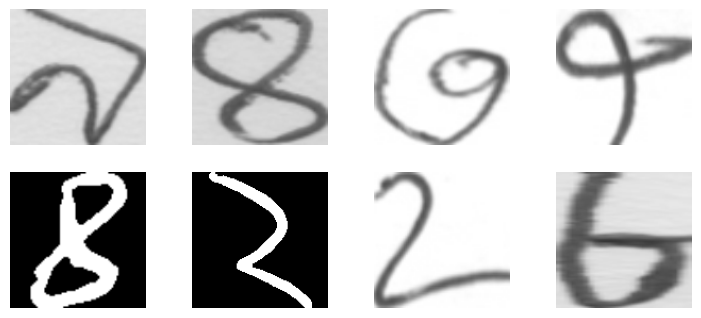

In [23]:
#This will create a grid of 8 random images from the input variable, with columns = 4 and figure size = (9, 6)

display_image(image_count = 8, images = input, index = index, columns =4, fig_size = (9, 6))

#### Input Labels

In [24]:
#Acquire the first 12,800 labels, and categorically reshape the array to form (12800,10) shape

labels = pd.read_csv("Bangla_MNIST/labels.csv")
labels = labels["digit"]
labels = tf.keras.utils.to_categorical(labels[:index+20])

print('Labels shape: {}\nLabels dtype: {}\nNumber of classes: {}\nNumber of data: {}'.format(
    labels.shape, labels.dtype, labels.shape[1], labels.shape[0]))

Labels shape: (12820, 10)
Labels dtype: float32
Number of classes: 10
Number of data: 12820


##

# Dataset Preprocessing

In [25]:
#Divide the inputs in train and test datasets, followed by batching.

x_train, x_test, y_train, y_test = train_test_split(input[:index], labels[:index], test_size=0.2, random_state=48)

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = test_dataset.batch(batch_size)
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

print("Shape of x_train:", x_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of x_test:", x_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of x_train: (10240, 128, 128, 3)
Shape of y_train: (10240, 10)
Shape of x_test: (2560, 128, 128, 3)
Shape of y_test: (2560, 10)


##

# Model Implementation

In [26]:
#Create model with VGG16 as backbone (untrainable weights), modify the fully connected dense layer classifier

VGG_base = tf.keras.applications.VGG16(input_shape=(128, 128, 3), include_top=False)
for layer in VGG_base.layers:
    layer.trainable = False

#Take output from block 1, convolution layer 2 since it gives better classification of edges
output_tensor = VGG_base.get_layer('block1_conv2').output
VGG = tf.keras.Model(inputs=VGG_base.input, outputs=output_tensor)

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), padding= 'same', activation='relu', input_shape=(128,128,3)),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(128, (3,3), padding= 'same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.7),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.7),
    tf.keras.layers.Dense(10, activation='sigmoid')
])

model.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 128)      0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 131072)            0         
                                                         

In [27]:
#Model training and evaluation

history = model.fit(train_dataset,
                    batch_size=batch_size,
                    epochs=10,
                    validation_data=test_dataset)

Epoch 1/10
160/160 [==============================] - 24s 61ms/step - loss: 2.3050 - accuracy: 0.0997 - val_loss: 2.3025 - val_accuracy: 0.0977
Epoch 2/10
160/160 [==============================] - 9s 53ms/step - loss: 2.3027 - accuracy: 0.1031 - val_loss: 2.3026 - val_accuracy: 0.0992
Epoch 3/10
160/160 [==============================] - 9s 58ms/step - loss: 2.3025 - accuracy: 0.1001 - val_loss: 2.3025 - val_accuracy: 0.0992
Epoch 4/10
160/160 [==============================] - 9s 55ms/step - loss: 2.3024 - accuracy: 0.1007 - val_loss: 2.3025 - val_accuracy: 0.1004
Epoch 5/10
160/160 [==============================] - 9s 57ms/step - loss: 2.3026 - accuracy: 0.1034 - val_loss: 2.3025 - val_accuracy: 0.1016
Epoch 6/10
160/160 [==============================] - 9s 55ms/step - loss: 2.3028 - accuracy: 0.1054 - val_loss: 2.3027 - val_accuracy: 0.1000
Epoch 7/10
160/160 [==============================] - 9s 55ms/step - loss: 2.3023 - accuracy: 0.1034 - val_loss: 2.3028 - val_accuracy: 0.102